## Data Cleaning and Imputation
* Drop columns with more than 40% missingness
* Impute the other missing values based on the complete columns
* Transformation and one-hot-encoding
* Cleaned data can be directly feed into models or saved for future use

In [3]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
import warnings
warnings.filterwarnings("ignore")

In [4]:
### import training and testing data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
n1,n2 = train.shape

### Exploring missing values
Explore missingness of each predictor on the training data

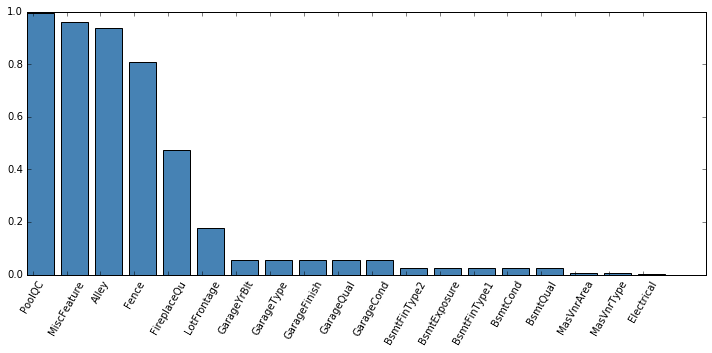

In [52]:
### remove certain columns
# remove SalePrice (response variable) from training data
train_dropped = train.drop("SalePrice", axis = 1)
# drop Utilities because it has only one value
train_dropped = train_dropped.drop('Utilities', axis = 1)
test_dropped = test.drop('Utilities', axis = 1)

### check missing data in each variable
# store number of missing values 
missing_num_train = train_dropped.isnull().sum()
# find columns with missingness
missing_column_train_index = (missing_num_train != 0)
missing_column_train_names = train_dropped.columns[missing_column_train_index]
missing_percent = missing_num_train[missing_column_train_index]/n1

# plot the missingness
missing_percent.sort(ascending=False)
# bar plot
bar = [i*1 for i in range(len(missing_percent))] 
bar_width = 0.8

fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(111)
ax1.bar(bar, missing_percent, width=bar_width, color = 'steelblue')
# add names
tickers = [i+0.2*(bar_width) for i in bar] 
plt.xticks(tickers, missing_percent.index.values, rotation = 60)

plt.tight_layout()
plt.show()

In [53]:
# drop columns with more than 40% missingness
dropped_columns = train_dropped.columns[missing_num_train >= 0.4 * n1]
train_dropped = train_dropped.drop(dropped_columns, axis = 1)
test_dropped = test_dropped.drop(dropped_columns, axis = 1)

Explore missingness in testing set:
* Explore the number of missingness in each variable in the testing set (columns with more than 40% missingness have been dropped);
* Combine missing columns in both training and testing sets for imputation

In [55]:
# columns with missingness in testing set
missing_num_test = test_dropped.isnull().sum()
missing_column_test_index = (missing_num_test != 0)
missing_column_test_names = test_dropped.columns[missing_column_test_index]

## Combine columns with missing values from both training and testing sets
missing_column_names = set().union(missing_column_test_names, 
missing_column_train_names)

Determine categorical or quantitative predictors of the remaining columns:
* variables with less than 15 values are set to be categorical
* non-numerical values also indicate categorical variables

In [57]:
### extract variables with less than 15 values and non-numerical values
value_num = [] #store number of unique values in each column
non_numerical_names = [] #non-numerical column names

for name in train_dropped.columns:
    # number of unique values in each column
    value_num.append(len(train_dropped[name].unique()))
    # check if the first value is numerical
    if not (train_dropped[name].dtype == np.dtype('int64') or 
    train_dropped[name].dtype == np.dtype('float64')):
        non_numerical_names.append(name)
# extract columns with less than 15 values       
value_num = np.asarray(value_num)
categorical_names = train_dropped.columns[value_num <= 15]

# the categorial predictors are the union of the two lists
categorical_final = list(set().union(list(categorical_names), non_numerical_names))

### Check which variables with missing values are categorical
# it is the intersect of categorical_final and missing_column_names
missing_cat_names = list(set(missing_column_names) & set(categorical_final))
# the rest are quantitative
missing_quant_names = list(set(missing_column_names)-set(missing_cat_names)
-set(dropped_columns))

### Imputation
Using variables without missing values as training set to impute missing values

* Categorical variables: regularized logistic
* Quantitative variables: try lasso and Ridge 

(tune the parameters and use the best model to impute missing values)

In [58]:
### training data for imputation 
# extract training data without missing values to use for imputation
complete_column_names = list(set(train_dropped.columns)
-set(missing_column_names))
complete_train = train_dropped[complete_column_names]
complete_test = test_dropped[complete_column_names]
# need to combine the complete data from training and testing sets
complete_data = pd.concat((complete_train,complete_test))
print "Dimension of the complete data: ", complete_data.shape
# turn quant variables into float numbers
quant_complete_names = list(set(complete_data.columns)-set(categorical_final))
for name in quant_complete_names:
    complete_data[name] = complete_data[name].astype(float)
# one-hot_encode the categorical columns
cat_complete_names = list(set(complete_train.columns)-set(quant_complete_names))
dummies = pd.get_dummies(complete_data[cat_complete_names])
# combine the cat and quant columns
data_for_impute = pd.concat([complete_data[quant_complete_names],
                              dummies], axis = 1)
# separate the training and testing data from data_for_impute
train_for_impute = data_for_impute.iloc[:n1]
test_for_impute = data_for_impute.iloc[n1:]

Dimension of the complete data:  (2919, 46)


In [59]:
### function to impute missing values for each column
## input 1: complete columns from training set
## input 2: complete columns from testing set
## input 3: column to impute in training data as a Pandas Series
## input 4: column to impute in testing data as a Pandas Series
## input 5: variable type: 1 = categorical; 2 = quantitative
#
## output: training and testing columns with missing data filled
def data_impute(train_complete, test_complete, train_impute, test_impute,
               variable_type):
    index1 = train_impute.isnull()
    index2 = test_impute.isnull()
    # response variable
    y_complete = np.concatenate((train_impute[index1 == False].values,
                              test_impute[index2 == False].values))
    y_train = train_impute[index1 == True].values
    y_test = test_impute[index2 == True].values
    # predictors
    x_complete = np.concatenate((train_complete[index1 == False].values,
                              test_complete[index2 == False].values), axis = 0)
    x_train = train_for_impute[index1 == True].values
    x_test = test_for_impute[index2 == True].values
    
    # categorical
    if variable_type == 1:
        # tune logistic regression model
        param, score = tune_logistic(x_complete, y_complete)
        print "The best param is {} with accuracy of {}.".format(param, score)
        # imputation
        model = LogisticRegression(C = param)
        model.fit(x_complete, y_complete)
    
    # quantitative
    elif variable_type == 2:
        # tune ridge or lasso regression
        penalty, param, score = tune_ridge_lasso(x_complete, y_complete)
        print "The penalty is L{} with best param of {} and accuracy of {}.".format(
        penalty, param, score)
        # imputation
        if penalty == 1:
            model = Lasso_Reg(alpha = param)
        elif penalty == 2:
            model = Ridge_Reg(alpha = param)
        model.fit(x_complete, y_complete)
    
    # impute the missing data 
    if y_train.shape[0] > 0:
        y1 = model.predict(x_train)
        train_impute[index1 == True] = y1
    if y_test.shape[0] > 0:
        y2 = model.predict(x_test)
        test_impute[index2 == True] = y2
    
    return train_impute, test_impute
 
### function to tune regularization parameter for logistic regression
## input: predictors x and response y
## output: best parameter and accuracy
## selection based on classification accuracy
def tune_logistic(x, y):
    #shuffe the data
    perm = range(y.shape[0])
    np.random.shuffle(perm)
    x = x[perm]
    y = y[perm]
    # split train and test sets (7:3)
    [x_train, x_test, y_train, y_test] = train_test_split(x, y, train_size=0.7)
    # set of paramters to test
    param_list = np.power(0.1, np.arange(-4, 4))
    # tune the model
    best_param = 0
    best_score = 0
    
    for param in param_list:
        log = LogisticRegression(C = param)
        log.fit(x_train, y_train)
        score = log.score(x_test, y_test)
        # update
        if score > best_score:
            best_score = score
            best_param = param
    
    return best_param, best_score
    
### function to tune ridge or lasso regression
## input: predictors x and response y
## output: penalty type (1: lasso, 2: ridge), best parameter and accuracy
## selection based on R^2
def tune_ridge_lasso(x, y):
    #shuffe the data
    perm = range(y.shape[0])
    np.random.shuffle(perm)
    x = x[perm]
    y = y[perm]
    # split train and test sets (7:3)
    [x_train, x_test, y_train, y_test] = train_test_split(x, y, train_size=0.7)
    # set of paramters to test
    param_list = np.power(0.1, np.arange(-7, 7))
    
    # tune the model
    best_param = 0
    best_score = 0
    best_penalty = 0
    
    for param in param_list:
        ridge = Ridge_Reg(alpha = param)
        ridge.fit(x_train, y_train)
        score1 = ridge.score(x_test, y_test)
        
        lasso = Lasso_Reg(alpha = param)
        lasso.fit(x_train, y_train)
        score2 = lasso.score(x_test, y_test)
    # compare between the two scores first
        if score1 > score2:
            penalty = 2
            score = score1
        else:
            penalty = 1
            score = score2
        # update
        if score > best_score:
            best_score = score
            best_param = param
            best_penalty = penalty
        
        return best_penalty, best_param, best_score

In [60]:
### impute missing values for categorical variables
print "CATEGORICAL:"
for name in missing_cat_names:
    print name
    train_dropped[name], test_dropped[name] = data_impute(
    train_for_impute,test_for_impute, train_dropped[name], test_dropped[name],1)
    
### impute missing values for categorical variables
print "QUANTITATIVE:"
for name in missing_quant_names:
    print name
    train_dropped[name], test_dropped[name] = data_impute(
    train_for_impute,test_for_impute, train_dropped[name], test_dropped[name],2)

CATEGORICAL:
MasVnrType
The best param is 10.0 with accuracy of 0.715765247411.
GarageType
The best param is 10.0 with accuracy of 0.784077201448.
BsmtFullBath
The best param is 0.1 with accuracy of 0.694063926941.
GarageQual
The best param is 0.001 with accuracy of 0.946924004825.
Exterior1st
The best param is 1.0 with accuracy of 0.520547945205.
GarageFinish
The best param is 10.0 with accuracy of 0.669481302774.
MSZoning
The best param is 1000.0 with accuracy of 0.932571428571.
Exterior2nd
The best param is 1.0 with accuracy of 0.522831050228.
BsmtCond
The best param is 100.0 with accuracy of 0.924882629108.
BsmtFinType2
The best param is 1.0 with accuracy of 0.87323943662.
BsmtHalfBath
The best param is 0.001 with accuracy of 0.938356164384.
Electrical
The best param is 0.01 with accuracy of 0.91095890411.
KitchenQual
The best param is 0.1 with accuracy of 0.815068493151.
BsmtQual
The best param is 10.0 with accuracy of 0.830985915493.
GarageCars
The best param is 10000.0 with accu

Most categorical variables have high accuracy rate. A few with around 0.5 accuracy are similar as random imputation. 

Most quantitative variables have relatively low R^2 on the imputation, but it is more accurate than directly assigning average values. 

### Transformation and one-hot encoding
* log-transform response variable
* transform quantitative predictors

In [94]:
# combine train and test predictors for one-hot encoding (in order to include all classes)
predictors = pd.concat((train_dropped, test_dropped))
# one-hot_encode the categorical columns
dummies = pd.get_dummies(predictors[categorical_final])
# combine the cat and quant columns
quant_names = list(set(train_dropped.columns)-set(categorical_final))
predictors_expanded = pd.concat([predictors[quant_names],dummies], axis = 1)

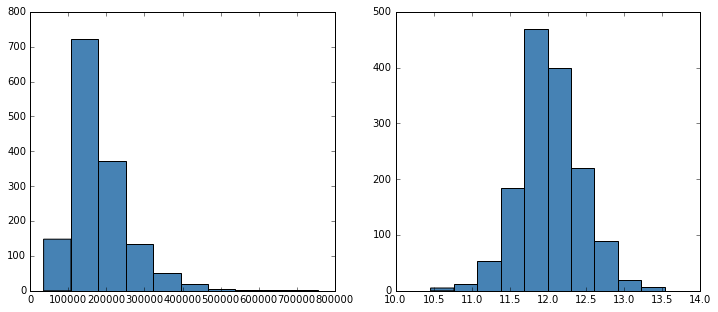

In [67]:
### Log transformation on SalePrice --> normal dist
# the response variable for the training set
y_train = train['SalePrice'].values

### check distribution of SalePrice
fig = plt.figure(figsize = (12, 5))
# original
ax1 = fig.add_subplot(121)
ax1.hist(y_train, color = 'steelblue')
# log transformation
ax2 = ax1 = fig.add_subplot(122)
ax2.hist(np.log(y_train), color = 'steelblue')

y_train_log = np.log(y_train)

Check relationship between response variable with each quantitative variable.

Transformation quantitative variables:
1. add a binary variable to indicate non-zero values if there are zero-values (indicating subgroups)
2. log transform if highly right skewed

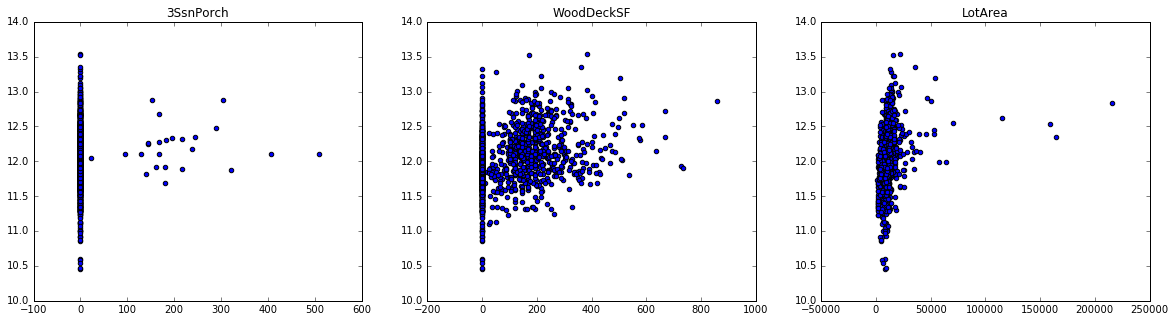

In [98]:
# # check relationship between response and each quant predictor
# for name in quant_names:
#     print name
#     fig = plt.figure(figsize = (5, 5))
#     ax1 = fig.add_subplot(111)
#     ax1.scatter(predictors_expanded[name].values[:n1, ],y_train_log)

### show a few representative ones
var_list = [0, 5, 3]

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i in range(len(var_list)):
    name =  quant_names[var_list[i]]
    ax[i].scatter(predictors_expanded[name].values[:n1, ],y_train_log) 
    ax[i].set_title(name)

The first plot shows a variable with most values as zero and a few non-zero values. It indicates two subgroups. Therefore, a binary variable will be created to indicate the non-zero values.

The middle plot represents variables with zero-values and the non-zero values are highly right skewed. The non-zero values will be log-transformed.

The last plot shows a variable that has no zero values but highly right-skewed. The values will be log-tranformed. 

In [83]:
# add binary variable to indicate non-zero values
add_binary_index = [0, 1, 2, 5, 6, 10, 11, 12, 13, 16, 17, 18, 19, 20]

for i in add_binary_index:
    name = quant_names[i]
    # add a binary column
    binary_col = np.copy(predictors_expanded[name].values)
    binary_col[binary_col > 0] = 1
    # combine to the predictor dataframe
    predictors_expanded[name+'-binary'] = binary_col
    
# log-transform skewed quant predictors
log_transform_index = [0, 1, 3, 4, 5, 6, 9, 10, 12, 17]

for i in log_transform_index:
    name = quant_names[i]
    # log transform
    predictors_expanded[name] = np.log(predictors_expanded[name].values+0.001)

In [84]:
# split into training and testing predictors
x_train = predictors_expanded.values[:n1, ]
x_test = predictors_expanded.values[n1:, ]

In [91]:
# save predictors and response variable for future use
np.savetxt('data/x_train_cleaned.txt', x_train, fmt='%.18e', delimiter=',')
np.savetxt('data/x_test_cleaned.txt', x_test, fmt='%.18e', delimiter=',')
np.savetxt('data/y_train_log.txt', y_train_log, fmt='%.18e', delimiter=',')

### Prediction
x_train, x_test and y_train_log can be used to build models and perform prediction. Here a simple lasso model is shown as an example. 

In [88]:
lasso =  Lasso_Reg (alpha = 0.01)
lasso.fit(x_train, y_train_log)
y_pred = lasso.predict(x_test)

# convert to original scale and save
submission = pd.read_csv('sample_submission.csv')
submission['SalePrice'] = np.exp(y_pred)
submission.to_csv('result.csv', sep = ',', index=False)